## Importing required libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [63]:
train_data = pd.read_csv('dataset/train.csv')
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Attributes in Dataset

* id = unique id for news articles
* title = title of the article
* author
* text = content of the article
* label 0 => not fake, 1 => fake

## Downloading Embeddings

In [64]:
import kaggle
kaggle.api.authenticate()

embeddings = kaggle.api.dataset_download_files(dataset='danielwillgeorge/glove6b100dtxt', path="./dataset", unzip=True)
print("Embedding Download Successful")

Dataset URL: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
Embedding Download Successful


## Preprocessing

In [65]:
# Finding null values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [66]:
# Dropping unnecessary columns
# pd.set_option('display.max_colwidth', 1)
train_data.drop(['id', 'title', 'author'], axis=1, inplace=True)
train_data.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [67]:
# Dropping rows which contain null values
print(f"Dimensions of Dataset before dropping null values {train_data.shape}")
train_data.dropna(axis=0, inplace=True)
print(f"Shape after dropping null values {train_data.shape}")

Dimensions of Dataset before dropping null values (20800, 2)
Shape after dropping null values (20761, 2)


In [68]:
train_df = train_data

## Text Preprocessing

In [69]:
# Lower Casing
train_df['text'] = train_data['text'].apply(lambda x: x.lower())
train_df.head()

,text,label
0,house dem aide: we didn’t even see comey’s let...,1
1,ever get the feeling your life circles the rou...,0
2,"why the truth might get you fired october 29, ...",1
3,videos 15 civilians killed in single us airstr...,1
4,print \nan iranian woman has been sentenced to...,1


In [70]:
# Remove Punctuations
train_df['text'] = train_df['text'].str.replace('[^A-Za-z0-9\s]', '')
train_df['text'] = train_df['text'].str.replace('\n', '')
train_df['text'] = train_df['text'].str.replace('\s+', ' ')
train_df.head()

,text,label
0,house dem aide: we didn’t even see comey’s let...,1
1,ever get the feeling your life circles the rou...,0
2,"why the truth might get you fired october 29, ...",1
3,videos 15 civilians killed in single us airstr...,1
4,print an iranian woman has been sentenced to s...,1


## EDA 

In [71]:
import os

os.makedirs("images", exist_ok=True)

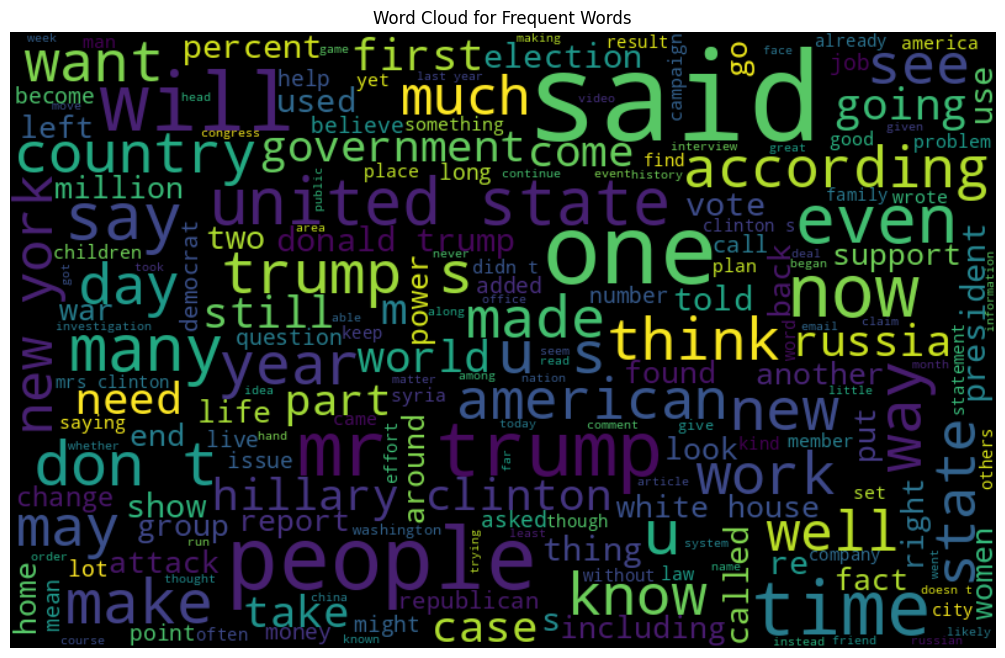

In [72]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in train_df['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Frequent Words")
plt.savefig("./images/1_frequent_words.png", bbox_inches='tight', pad_inches=0)
plt.show()

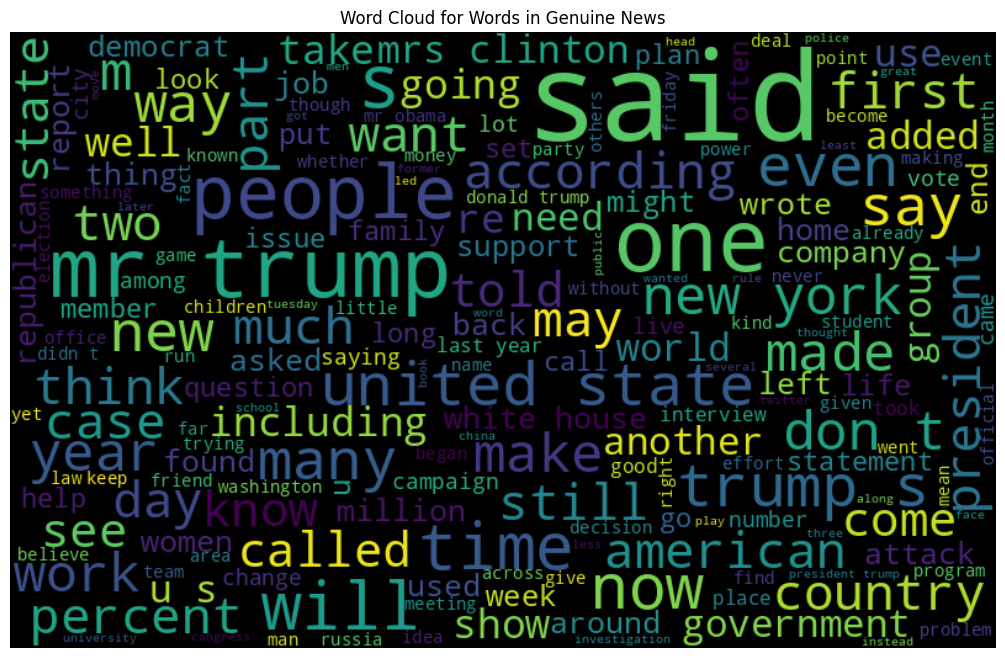

In [73]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in train_df['text'][train_df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Words in Genuine News")
plt.savefig("./images/2_genuine_words.png", bbox_inches='tight', pad_inches=0)
plt.show()

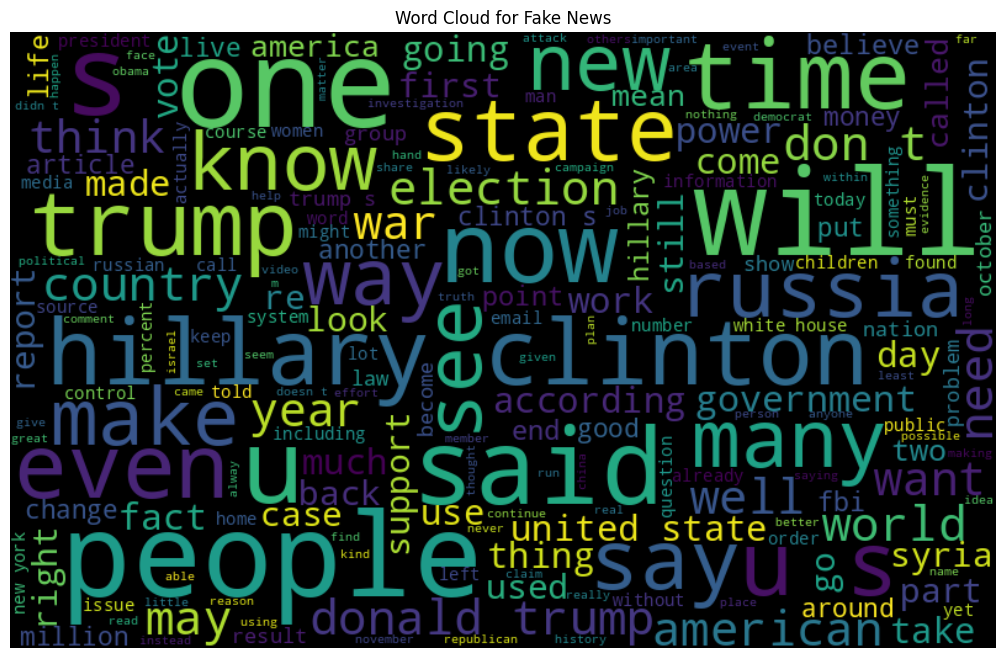

In [74]:
# visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in train_df['text'][train_df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Fake News")
plt.savefig("./images/3_fake_news.png", bbox_inches='tight', pad_inches=0)
plt.show()

## Word Embedding Creation

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

239556

In [43]:
# padding data
sequences = tokenizer.texts_to_sequences(train_df['text'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [44]:
# create embedding index
embedding_index = {}
with open('./dataset/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [45]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [47]:
padded_seq[1]

array([   359,    114,      1,   1739,     89,    193,   5191,      1,
        29168,    544,     67,   2463,      6,      5,   2201,    491,
          675,      1,   1724,   5627,    115,     74,    935,      1,
          291,    492,     10,   2089,      6,  18251,    945,  21175,
         3179,   2845,    782,    880,     49,     90,    370,      2,
         5460,     49,   2171,   3352,      9,      1,  11444,      3,
           49,    237,      1,    124,   2345,  92527,   3298,   3833,
            7,   3757,   3352,    942,      3,    270,   3644,    115,
        10185,  58259,     12,     72,   3423,     87,    329,     56,
           48,     94,   3399,      5,  21175,  10441,    708,      1,
           68,      3,      1,    616,   2597,     98,   2612,      6,
         8398,      7,      1,    602,    830,   1616,    758,     58,
          253,     15,     32,     82,  23502,     15,      2,     33,
           38,   1039,     13,      2,  25181,    447,      3,      1,
      

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_seq, train_df['label'], test_size=0.20, random_state=42, stratify=train_df['label'])

In [49]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Sequential

model = Sequential([
     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
     Dropout(0.2),
     LSTM(128, return_sequences=True),
     LSTM(128),
     Dropout(0.2),
     Dense(512),
     Dropout(0.2),
     Dense(256),
     Dense(1, activation='sigmoid')
])


In [50]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    23,955,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,955,700 (91.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,955,700 (91.38 MB)

In [51]:
# train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 675s 5s/step - accuracy: 0.6325 - loss: 0.6503 - val_accuracy: 0.6516 - val_loss: 0.6280
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 742s 6s/step - accuracy: 0.6664 - loss: 0.6256 - val_accuracy: 0.6222 - val_loss: 0.6286
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.6280 - loss: 0.6339 - val_accuracy: 0.7294 - val_loss: 0.5554
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.7492 - loss: 0.5222 - val_accuracy: 0.8546 - val_loss: 0.3352
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.8673 - loss: 0.3376 - val_accuracy: 0.9066 - val_loss: 0.2307


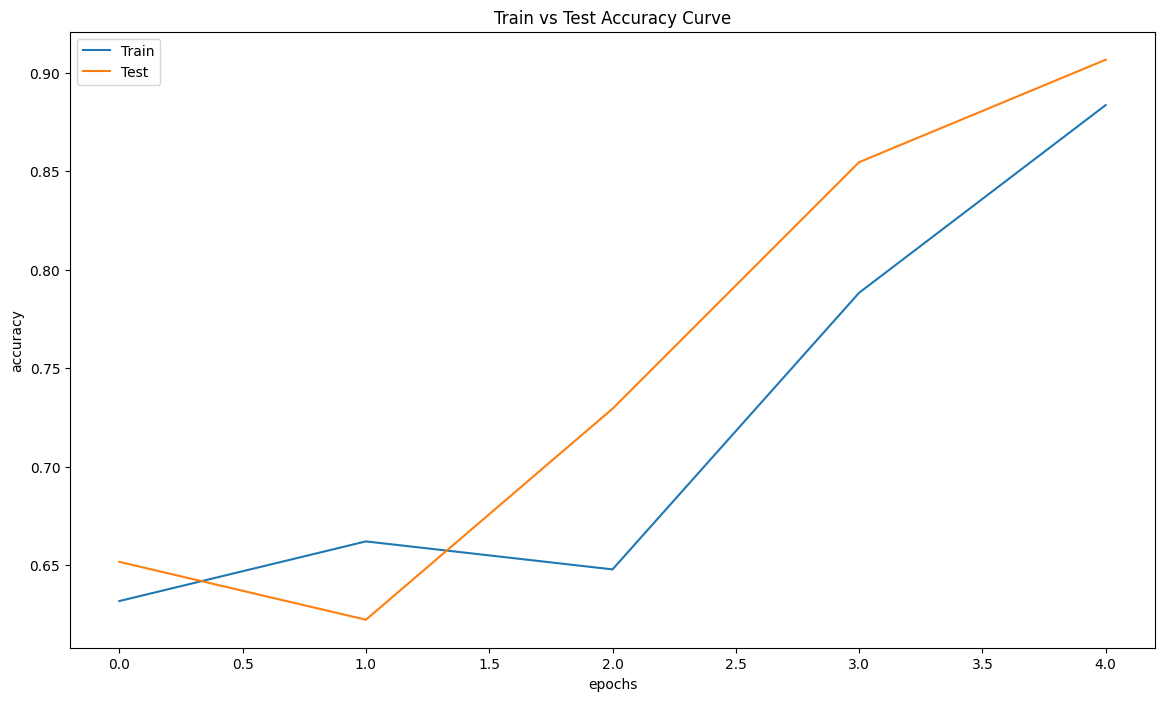

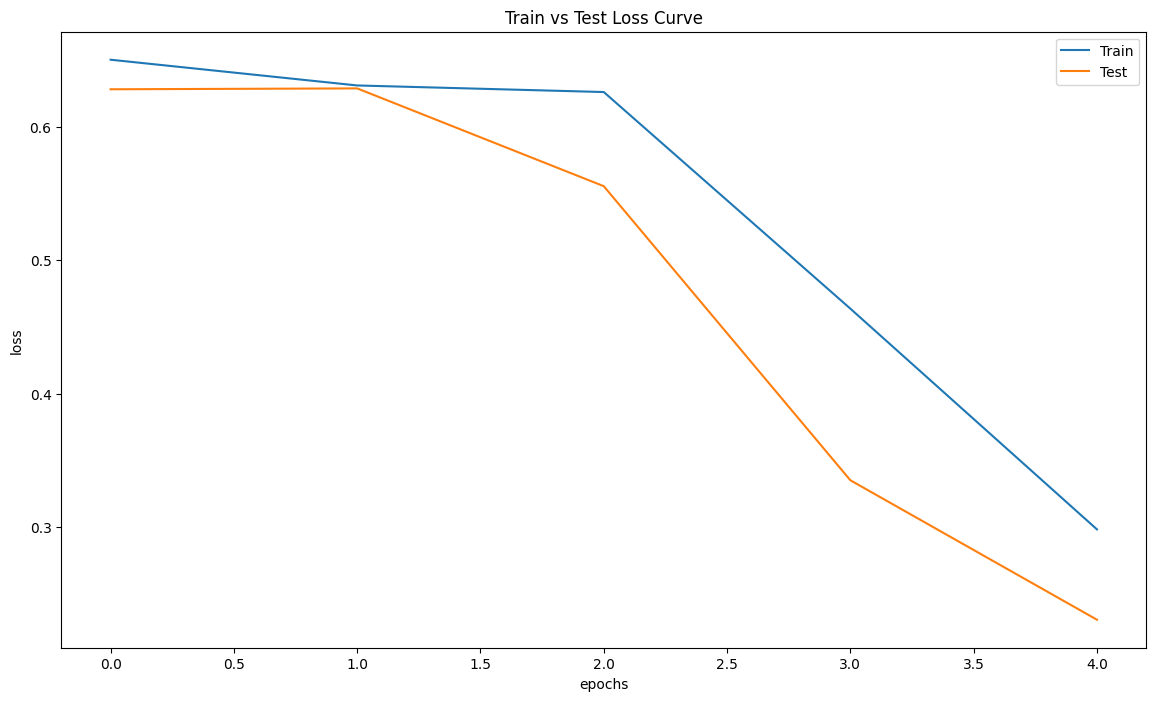

In [60]:
# visualize the results
plt.figure(figsize=(14, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.title("Train vs Test Accuracy Curve")
plt.savefig("./images/4_train_vs_test.png")
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.title("Train vs Test Loss Curve")
plt.savefig("./images/5_train_vs_test_loss.png")
plt.show()

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step


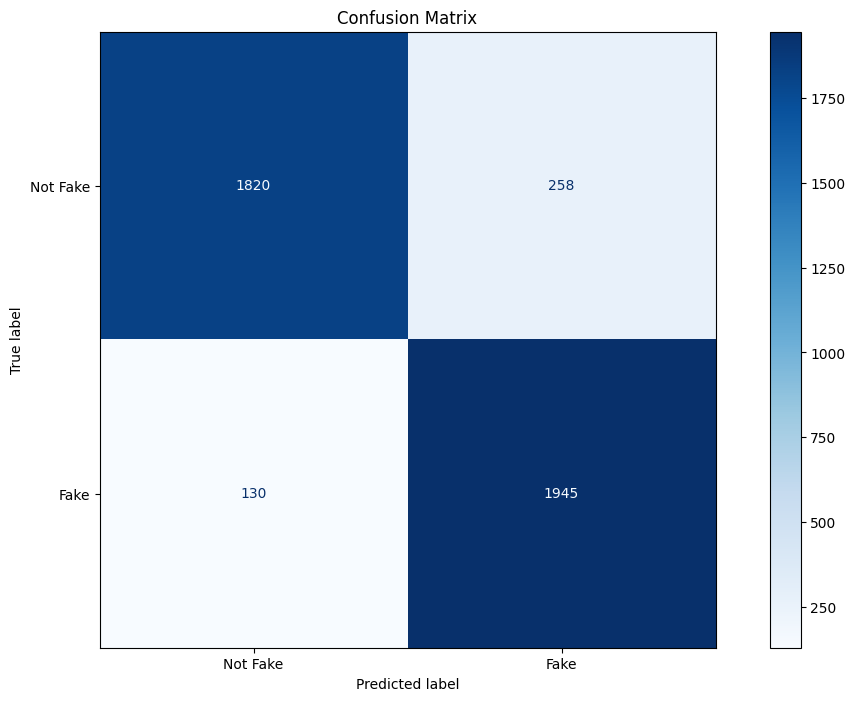

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create figure with desired size
fig, ax = plt.subplots(figsize=(14, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fake', 'Fake'])
disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass custom ax

# Add title and save
plt.title("Confusion Matrix")
plt.savefig("./images/6_confusion_matrix.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [54]:
model.save("detection_model.keras")
model.save("detection_model.h5")

In [55]:
import pickle

with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

In [56]:
user_input = input("Enter news")
tokenizer = pickle.load(open("tokenizer.pkl", "rb"))
user_sequences = tokenizer.texts_to_sequences(user_input)
user_padded = pad_sequences(user_sequences, maxlen=500)

predictions = model.predict(user_padded)
print("Predictions:", predictions)

threshold = 0.5
classification = "1" if predictions[0][0] > threshold else "0"
print("Classification:", classification)

198/198 ━━━━━━━━━━━━━━━━━━━━ 56s 283ms/step
Predictions: [[0.99007416]
 [0.99026847]
 [0.99057895]
 ...
 [0.99007416]
 [0.9897903 ]
 [0.99080557]]
Classification: 1


In [58]:
test_data = pd.read_csv('./dataset/test.csv')
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
test_data = test_data['text']
test_data.to_csv('./dataset/testset.csv')